In [1]:
import tensorflow as tf

### Managing graph
Below code doesn't do any computation or any variable initilization. It just creates a computation graph. To evaluate the 'f', we need to open a Tensorflow session and use it to initilize the variables and evaluate the f and then close the session.

In [2]:
x = tf.Variable(3, name="x")
y = tf.Variable(4, name="y")
f = x*x*y + y + 2

### Initialize the session and variables

In [3]:
sess = tf.Session()
sess.run(x.initializer)
sess.run(y.initializer)
result1 = sess.run(f)
print(result1)
sess.close()

42


### Different way to initialize session and variables
1. To avoid repetitive *sess.run()*, we can run with *'with*' block, where the session is set as a default session.
2. *x.initializer.run()* is equivalent to *tf.get_default_session.run(x.initializer)*
3. f.eval() is equivalent to *tf.get_default_session.run(f)*
4. The session is automatically created and closed.

In [4]:
with tf.Session() as sess:
    x.initializer.run()
    y.initializer.run()
    result2 = f.eval()
print(result2)

42


### Avoiding initializing each variable in a session
1. We can avoid running initializer for each variable by using *global_variables_initiazlier()* function.
2. This doesn't perform the initialization immediately, but rather creates a node in the graph that will initialize all the variables when it is run.

In [5]:
init = tf.global_variables_initializer() #prepare an init node

with tf.Session() as sess:
    init.run() #actually initialize all the variables
    result3 = f.eval()
print(result3)

42


### Initializing Interactive session for jupyter
1. Difference between regular session and interactive session is that when an InteractiveSession is created it automatically sets itself as the default session.
2. We don't need a *'with'* block
3. We need to close the session manually when we are done with the session.

In [6]:
sess = tf.InteractiveSession()
init = tf.global_variables_initializer()
init.run()
result4 = f.eval()
print(result4)
sess.close()

42


Tensorflow programs are usually split into two parts. 
1. Computation graph (construction phase)
2. Running it (execution phase)

Construction phase typically builds a computation graph representing the ML and the computations required to train it.

Execution phase generally runs a loop that evaluates a training step repeatedly (for example, one step per mini-batch), gradually imporving the model parameters.

# Managing Graphs

1. Any node created will be automatically added to default graph
2. To manage multiple graphs independent graphs, we need to create new graph.
3. Temporarily a graph can be made default by creating nodes within the *'with'* block
4. Default graph can be reset by running *tf.reset_default_graph()*

In [7]:
x1 = tf.Variable(1)
x1.graph is tf.get_default_graph()

True

In [8]:
graph = tf.Graph()
with graph.as_default():
    x2 = tf.Variable(2)

print(x2.graph is graph)
print(x2.graph is tf.get_default_graph())

True
False


# Lifecycle of a Node Value
1. Tensor flow checks the dependenant nodes before evaluating the nodes that are called.
2. All the node values are dropped between the graph runs, except variable values, which are maintained by the session across graph runs.
3. Variable starts its life when its initializer is run, and it ends when the session is closed.
4. In a single process Tensorflow, mulitple sessions do not share any state, even if they resuse the same graph (each session would have its own copy of every variable)
5. In distributed Tensorflow, variable state is stored on the servers, not in the sessions, so multiple sessions can share the same variable.

In [9]:
w = tf.constant(3)
x = w + 2
y = x + 5
z = x + 3

with tf.Session() as sess:
    print(y.eval())
    print(z.eval())

with tf.Session() as sess:
    y_val, z_val = sess.run([y, z])
    print(y_val)
    print(z_val)

10
8
10
8


### Tensorflow Operations

1. Tensorflow operations can take any number of inputs and produce any number of outputs.
2. Simply called as **ops**
3. Addition and Multiplication ops can take two inputs and produce one output
4. Constant ops take no inputs and also called as *source ops*
5. Inputs and outputs are called multidimensional arrays called tensors. Tesors have shape and type.

### Linear Regression in Tensorflow

In [10]:
import numpy as np
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
m, n = housing.data.shape
housing_data_plus_bias = np.c_[np.ones((m, 1)), housing["data"]]

X = tf.constant(housing_data_plus_bias, dtype=tf.float32, name = "X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name = "y")
XT = tf.transpose(X)
theta = tf.matmul(tf.matmul(tf.matrix_inverse(tf.matmul(XT, X)), XT), y)

with tf.Session() as sess:
    theta_value = sess.run(theta)

In [11]:
theta_value

array([[ -3.74651413e+01],
       [  4.35734153e-01],
       [  9.33829229e-03],
       [ -1.06622010e-01],
       [  6.44106984e-01],
       [ -4.25131839e-06],
       [ -3.77322501e-03],
       [ -4.26648885e-01],
       [ -4.40514028e-01]], dtype=float32)

### Linear Regression with Numpy

In [12]:
X = housing_data_plus_bias
y = housing.target.reshape(-1, 1)

theta_numpy = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
theta_numpy

array([[ -3.69419202e+01],
       [  4.36693293e-01],
       [  9.43577803e-03],
       [ -1.07322041e-01],
       [  6.45065694e-01],
       [ -3.97638942e-06],
       [ -3.78654265e-03],
       [ -4.21314378e-01],
       [ -4.34513755e-01]])

### Linear Regression with Scikit-Learn

In [13]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing.data, housing.target.reshape(-1,1))

print(np.r_[lin_reg.intercept_.reshape(-1, 1), lin_reg.coef_.T])

[[ -3.69419202e+01]
 [  4.36693293e-01]
 [  9.43577803e-03]
 [ -1.07322041e-01]
 [  6.45065694e-01]
 [ -3.97638942e-06]
 [ -3.78654265e-03]
 [ -4.21314378e-01]
 [ -4.34513755e-01]]


# Implementing Gradient Descent
#### Normalizing input features before performing gardient descent

In [14]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_housing_data = scaler.fit_transform(housing.data)
scaled_housing_data_plus_bias = np.c_[np.ones((m, 1)), scaled_housing_data]

#### Manually computing Gradients using Tensorflow

In [15]:
tf.reset_default_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
gradients = 2/m * tf.matmul(tf.transpose(X), error)
training_op = tf.assign(theta, theta - learning_rate * gradients)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(training_op)
    
    best_theta = theta.eval()

Epoch 0 MSE = 2.75443
Epoch 100 MSE = 0.632222
Epoch 200 MSE = 0.57278
Epoch 300 MSE = 0.558501
Epoch 400 MSE = 0.549069
Epoch 500 MSE = 0.542288
Epoch 600 MSE = 0.537379
Epoch 700 MSE = 0.533822
Epoch 800 MSE = 0.531243
Epoch 900 MSE = 0.529371


In [16]:
best_theta

array([[  2.06855226e+00],
       [  7.74078071e-01],
       [  1.31192386e-01],
       [ -1.17845096e-01],
       [  1.64778158e-01],
       [  7.44080753e-04],
       [ -3.91945168e-02],
       [ -8.61356616e-01],
       [ -8.23479712e-01]], dtype=float32)

### Using autodiff
1. It is not always easy to derive gradient from the cost function
2. It becomes difficult, tedious and error prone to derive gradient
3. Example: *gradients = tf.gradients(mse, [theta])[0]*
4. The *gradients()* function take an op(in this case mse) and a list of variables(in this case just theta), and it crates a list of ops(one per variable) to compute the gradients of the op with regards to each variable. So the gradients node will compute the gradient vector of the MSE with regards to *theta.*

In [17]:
tf.reset_default_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
gradients = tf.gradients(mse, [theta])[0] #Changed code here for autodiff
training_op = tf.assign(theta, theta - learning_rate * gradients)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(training_op)
    
    best_theta = theta.eval()
    
best_theta

Epoch 0 MSE = 2.75443
Epoch 100 MSE = 0.632222
Epoch 200 MSE = 0.57278
Epoch 300 MSE = 0.558501
Epoch 400 MSE = 0.549069
Epoch 500 MSE = 0.542288
Epoch 600 MSE = 0.537379
Epoch 700 MSE = 0.533822
Epoch 800 MSE = 0.531243
Epoch 900 MSE = 0.529371


array([[  2.06855249e+00],
       [  7.74078071e-01],
       [  1.31192386e-01],
       [ -1.17845066e-01],
       [  1.64778143e-01],
       [  7.44078017e-04],
       [ -3.91945094e-02],
       [ -8.61356676e-01],
       [ -8.23479772e-01]], dtype=float32)

### Using Tensorflow out of the box Gradient Descent Optimizer

In [18]:
tf.reset_default_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate) # Optimizier
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(training_op)
    
    best_theta = theta.eval()
    
best_theta

Epoch 0 MSE = 2.75443
Epoch 100 MSE = 0.632222
Epoch 200 MSE = 0.57278
Epoch 300 MSE = 0.558501
Epoch 400 MSE = 0.549069
Epoch 500 MSE = 0.542288
Epoch 600 MSE = 0.537379
Epoch 700 MSE = 0.533822
Epoch 800 MSE = 0.531243
Epoch 900 MSE = 0.529371


array([[  2.06855249e+00],
       [  7.74078071e-01],
       [  1.31192386e-01],
       [ -1.17845066e-01],
       [  1.64778143e-01],
       [  7.44078017e-04],
       [ -3.91945094e-02],
       [ -8.61356676e-01],
       [ -8.23479772e-01]], dtype=float32)

### Using out of the box Momentum optimizer

In [19]:
tf.reset_default_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.9) # Optimizier
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(training_op)
    
    best_theta = theta.eval()
    
best_theta

Epoch 0 MSE = 2.75443
Epoch 100 MSE = 0.527316
Epoch 200 MSE = 0.524414
Epoch 300 MSE = 0.524328
Epoch 400 MSE = 0.524322
Epoch 500 MSE = 0.524321
Epoch 600 MSE = 0.524321
Epoch 700 MSE = 0.52432
Epoch 800 MSE = 0.524321
Epoch 900 MSE = 0.524321


array([[ 2.06855798],
       [ 0.82961673],
       [ 0.11875112],
       [-0.26552212],
       [ 0.30569226],
       [-0.00450316],
       [-0.03932616],
       [-0.89989167],
       [-0.87054664]], dtype=float32)

# Feeding data to the Training Algorithm

#### placeholder() function:
1. In context of mini batch gradient descent, we need a way to replace X and y at every iteration with the next mini batch. This can be easily done with tensorflow placeholders
2. These nodes are special because they don't actually perform any computation, they just output the data ou tell them to output at runtime.
3. Placeholders are typically used to pass training data to Tensorflow during training. 
4. We should specify a value at runtime for a placeholder, or we will get an exception.
5. Optionally, size of the placeholder can initially set.

In [20]:
# Using placeholder() function
A = tf.placeholder(tf.float32, shape=(None, 3))
B = A + 5

with tf.Session() as sess:
    B_val_1 = B.eval(feed_dict={A: [[1,2,3]]})
    B_val_2 = B.eval(feed_dict={A: [[4,5,6], [7,8,9]]})

print(B_val_1)
print(B_val_2)

[[ 6.  7.  8.]]
[[  9.  10.  11.]
 [ 12.  13.  14.]]


### Implementing Mini Batch Gradient Descent

In [21]:
tf.reset_default_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=(None, n+1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

batch_size = 100
n_batches = int(np.ceil(m / batch_size))

def fetch_batch(epoch, batch_index, batch_size):
    np.random.seed(epoch * n_batches + batch_index)  
    indices = np.random.randint(m, size=batch_size)  
    X_batch = scaled_housing_data_plus_bias[indices] 
    y_batch = housing.target.reshape(-1, 1)[indices]
    return X_batch, y_batch

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})

    best_theta = theta.eval()
    
best_theta    

array([[ 2.07144761],
       [ 0.84620118],
       [ 0.11558535],
       [-0.26835832],
       [ 0.32982782],
       [ 0.00608358],
       [ 0.07052915],
       [-0.87988573],
       [-0.86342508]], dtype=float32)

# Saving and Restoring Models
1. Once models are trained, we need to save parameters to disk to compare different models performance.
2. To retrieve parameters if your model crashes during training.
3. Need to save checkpoints at regular intervals to recover if model crashes during training phase.
4. Need to create a Saver node at the end of construction phase and then in the execution phase call *save()* method when ever we want to save the model
5. Restoring a model is also easy. Just need to start the session with *saver.restore("path")* instead of *sess.run(init)*
6. By default a Saver node saves and restores all the variables under their own name, but we can change their names when saving them as saver = tf.train.Saver({"weights": theta})
7. *saver = tf.train.import_meta_graph("/tmp/my_model_final.ckpt.meta")*

# Visualizing the Graphs
### Inside Jupyter

In [22]:
tf.reset_default_graph()
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = b"<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))
    
show_graph(tf.get_default_graph().as_graph_def())

In [40]:
from datetime import datetime

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)

tf.reset_default_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=(None, n + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

mse_summary = tf.summary.scalar('MSE', mse)
file_writer = tf.summary.FileWriter(logdir, sess.graph)

n_epochs = 10
batch_size = 100
n_batches = int(np.ceil(m / batch_size))

with tf.Session() as sess:                                                       
    sess.run(init)                                                                

    for epoch in range(n_epochs):                                                 
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            if batch_index % 10 == 0:
                summary_str = mse_summary.eval(feed_dict={X: X_batch, y: y_batch})
                step = epoch * n_batches + batch_index
                file_writer.add_summary(summary_str, step)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})

    best_theta = theta.eval()
    
file_writer.close()

In [34]:
best_theta

array([[ 2.07001591],
       [ 0.82045609],
       [ 0.1173173 ],
       [-0.22739051],
       [ 0.31134021],
       [ 0.00353193],
       [-0.01126994],
       [-0.91643935],
       [-0.87950081]], dtype=float32)

In [ ]:
#python -m tensorflow.tensorboard --logdir=path/to/log-directory
#http://localhost:6006
#python -m tensorflow.tensorboard --logdir='E:\GitHub Main\Python-Handson-Projects\tf_logs\run-20170803181200\'

### Name Scopes
1. A Name Scope is used to create a group of related nodes.
2. Name scopes avoid cluttering of tensorboard graphs when there are many graphs in a NN
3. Below code modifies the *error* and *mse* nodes and places them within *loss* name scope.

In [53]:
def fetch_batch(epoch, batch_index, batch_size):
    np.random.seed(epoch * n_batches + batch_index)  
    indices = np.random.randint(m, size=batch_size) 
    X_batch = scaled_housing_data_plus_bias[indices] 
    y_batch = housing.target.reshape(-1, 1)[indices] 
    return X_batch, y_batch

tf.reset_default_graph()
from datetime import datetime

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)

n_epochs = 1000
learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=(None, n+1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")
theta = tf.Variable(tf.random_uniform([n+1, 1], -1.0, 1.0, seed = 42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")

with tf.name_scope("loss") as scope:
    error = y_pred - y
    mse = tf.reduce_mean(tf.square(error), name="mse")
    
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

mse_summary = tf.summary.scalar('MSE', mse)
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

n_epochs = 10
batch_size = 100
n_batches = int(np.ceil(m/batch_size))

with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            if batch_index % 10 == 0:
                summary_str = mse_summary.eval(feed_dict={X: X_batch, y: y_batch})
                step = epoch * n_batches + batch_index
                file_writer.add_summary(summary_str, step)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})

    best_theta = theta.eval()

file_writer.flush()
file_writer.close()
print("Best theta:")
print(best_theta)       

Best theta:
[[ 2.07001591]
 [ 0.82045609]
 [ 0.1173173 ]
 [-0.22739051]
 [ 0.31134021]
 [ 0.00353193]
 [-0.01126994]
 [-0.91643935]
 [-0.87950081]]


In [55]:
print(error.op.name)
print(mse.op.name)

loss/sub
loss/mse


In [56]:
tf.reset_default_graph()

a1 = tf.Variable(0, name="a")      # name == "a"
a2 = tf.Variable(0, name="a")      # name == "a_1"

with tf.name_scope("param"):       # name == "param"
    a3 = tf.Variable(0, name="a")  # name == "param/a"

with tf.name_scope("param"):       # name == "param_1"
    a4 = tf.Variable(0, name="a")  # name == "param_1/a"

for node in (a1, a2, a3, a4):
    print(node.op.name)

a
a_1
param/a
param_1/a


### Modularity and Sharing Variables
Check out https://github.com/ageron/handson-ml/blob/master/09_up_and_running_with_tensorflow.ipynb

#### Exercise Problem 12

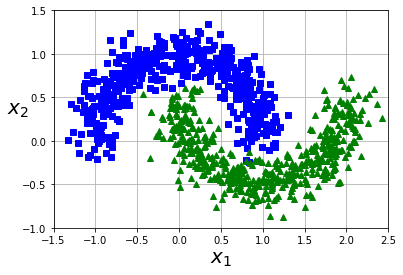

In [63]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

m = 1000
X, y = make_moons(n_samples=m, noise=0.15, random_state=42)

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

In [74]:
bias = np.ones((m, 1))
X_plus_bias = np.c_[bias, X]
y_columns = y.reshape(-1, 1)

test_ratio = 0.2
test_size = int(test_ratio * m)
X_train = X_plus_bias[: -test_size]
y_train = y_columns[: -test_size]
X_test = X_plus_bias[-test_size:]
y_test = y_columns[-test_size:]

In [101]:
tf.reset_default_graph()
n_epochs = 1000
learning_rate = 0.01
batch_size = 50
n_batches = int(np.ceil(m / batch_size))

def random_batch(X_train, y_train, batch_size):
    rnd_indices = np.random.randint(0, len(X_train), batch_size)
    X_batch = X_train[rnd_indices]
    y_batch = y_train[rnd_indices]
    return X_batch, y_batch

X = tf.placeholder(tf.float32, shape=(None, 3), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")
theta = tf.Variable(tf.random_uniform([3, 1], -1.0, 1.0, seed=42), name="theta")
logit = tf.matmul(X, theta, name="logit")
y_proba = 1/(1+tf.exp(-logit))
loss = tf.losses.log_loss(y, y_proba)

optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = random_batch(X_train, y_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val = loss.eval({X: X_test, y: y_test})
        if epoch % 100 == 0:
            print("Epoch:", epoch, "\tLoss:", loss_val)

    y_proba_val = y_proba.eval(feed_dict={X: X_test, y: y_test})

Epoch: 0 	Loss: 0.876161
Epoch: 100 	Loss: 0.355985
Epoch: 200 	Loss: 0.317977
Epoch: 300 	Loss: 0.303854
Epoch: 400 	Loss: 0.2968
Epoch: 500 	Loss: 0.292925
Epoch: 600 	Loss: 0.291275
Epoch: 700 	Loss: 0.290412
Epoch: 800 	Loss: 0.289057
Epoch: 900 	Loss: 0.288703


In [90]:
from sklearn.metrics import precision_score, recall_score
y_pred = (y_proba_val >= 0.5)
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", precision_score(y_test, y_pred))

Precision: 0.839622641509
Recall: 0.839622641509


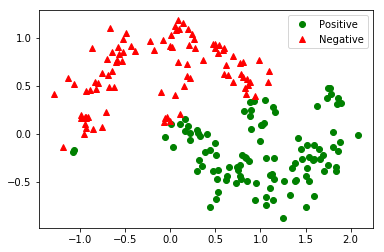

In [91]:
y_pred_idx = y_pred.reshape(-1) # a 1D array rather than a column vector
plt.plot(X_test[y_pred_idx, 1], X_test[y_pred_idx, 2], 'go', label="Positive")
plt.plot(X_test[~y_pred_idx, 1], X_test[~y_pred_idx, 2], 'r^', label="Negative")
plt.legend()
plt.show()

In [97]:
for epoch in range(n_epochs):
    for batch_index in range(n_batches):
        print(epoch, batch_index)

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 16
1 17
1 18
1 19
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 11
2 12
2 13
2 14
2 15
2 16
2 17
2 18
2 19
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
3 10
3 11
3 12
3 13
3 14
3 15
3 16
3 17
3 18
3 19
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
4 10
4 11
4 12
4 13
4 14
4 15
4 16
4 17
4 18
4 19
5 0
5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
5 9
5 10
5 11
5 12
5 13
5 14
5 15
5 16
5 17
5 18
5 19
6 0
6 1
6 2
6 3
6 4
6 5
6 6
6 7
6 8
6 9
6 10
6 11
6 12
6 13
6 14
6 15
6 16
6 17
6 18
6 19
7 0
7 1
7 2
7 3
7 4
7 5
7 6
7 7
7 8
7 9
7 10
7 11
7 12
7 13
7 14
7 15
7 16
7 17
7 18
7 19
8 0
8 1
8 2
8 3
8 4
8 5
8 6
8 7
8 8
8 9
8 10
8 11
8 12
8 13
8 14
8 15
8 16
8 17
8 18
8 19
9 0
9 1
9 2
9 3
9 4
9 5
9 6
9 7
9 8
9 9
9 10
9 11
9 12
9 13
9 14
9 15
9 16
9 17
9 18
9 19
10 0
10 1
10 2
10 3
10 4
10 5
10 6
10 7
10 8
10 9
10 10
10 11
10 12
10 13
10 14
10 15
10 16
10 17
10

95 7
95 8
95 9
95 10
95 11
95 12
95 13
95 14
95 15
95 16
95 17
95 18
95 19
96 0
96 1
96 2
96 3
96 4
96 5
96 6
96 7
96 8
96 9
96 10
96 11
96 12
96 13
96 14
96 15
96 16
96 17
96 18
96 19
97 0
97 1
97 2
97 3
97 4
97 5
97 6
97 7
97 8
97 9
97 10
97 11
97 12
97 13
97 14
97 15
97 16
97 17
97 18
97 19
98 0
98 1
98 2
98 3
98 4
98 5
98 6
98 7
98 8
98 9
98 10
98 11
98 12
98 13
98 14
98 15
98 16
98 17
98 18
98 19
99 0
99 1
99 2
99 3
99 4
99 5
99 6
99 7
99 8
99 9
99 10
99 11
99 12
99 13
99 14
99 15
99 16
99 17
99 18
99 19
100 0
100 1
100 2
100 3
100 4
100 5
100 6
100 7
100 8
100 9
100 10
100 11
100 12
100 13
100 14
100 15
100 16
100 17
100 18
100 19
101 0
101 1
101 2
101 3
101 4
101 5
101 6
101 7
101 8
101 9
101 10
101 11
101 12
101 13
101 14
101 15
101 16
101 17
101 18
101 19
102 0
102 1
102 2
102 3
102 4
102 5
102 6
102 7
102 8
102 9
102 10
102 11
102 12
102 13
102 14
102 15
102 16
102 17
102 18
102 19
103 0
103 1
103 2
103 3
103 4
103 5
103 6
103 7
103 8
103 9
103 10
103 11
103 12
103 13
103 14


162 4
162 5
162 6
162 7
162 8
162 9
162 10
162 11
162 12
162 13
162 14
162 15
162 16
162 17
162 18
162 19
163 0
163 1
163 2
163 3
163 4
163 5
163 6
163 7
163 8
163 9
163 10
163 11
163 12
163 13
163 14
163 15
163 16
163 17
163 18
163 19
164 0
164 1
164 2
164 3
164 4
164 5
164 6
164 7
164 8
164 9
164 10
164 11
164 12
164 13
164 14
164 15
164 16
164 17
164 18
164 19
165 0
165 1
165 2
165 3
165 4
165 5
165 6
165 7
165 8
165 9
165 10
165 11
165 12
165 13
165 14
165 15
165 16
165 17
165 18
165 19
166 0
166 1
166 2
166 3
166 4
166 5
166 6
166 7
166 8
166 9
166 10
166 11
166 12
166 13
166 14
166 15
166 16
166 17
166 18
166 19
167 0
167 1
167 2
167 3
167 4
167 5
167 6
167 7
167 8
167 9
167 10
167 11
167 12
167 13
167 14
167 15
167 16
167 17
167 18
167 19
168 0
168 1
168 2
168 3
168 4
168 5
168 6
168 7
168 8
168 9
168 10
168 11
168 12
168 13
168 14
168 15
168 16
168 17
168 18
168 19
169 0
169 1
169 2
169 3
169 4
169 5
169 6
169 7
169 8
169 9
169 10
169 11
169 12
169 13
169 14
169 15
169 16
169 1

282 12
282 13
282 14
282 15
282 16
282 17
282 18
282 19
283 0
283 1
283 2
283 3
283 4
283 5
283 6
283 7
283 8
283 9
283 10
283 11
283 12
283 13
283 14
283 15
283 16
283 17
283 18
283 19
284 0
284 1
284 2
284 3
284 4
284 5
284 6
284 7
284 8
284 9
284 10
284 11
284 12
284 13
284 14
284 15
284 16
284 17
284 18
284 19
285 0
285 1
285 2
285 3
285 4
285 5
285 6
285 7
285 8
285 9
285 10
285 11
285 12
285 13
285 14
285 15
285 16
285 17
285 18
285 19
286 0
286 1
286 2
286 3
286 4
286 5
286 6
286 7
286 8
286 9
286 10
286 11
286 12
286 13
286 14
286 15
286 16
286 17
286 18
286 19
287 0
287 1
287 2
287 3
287 4
287 5
287 6
287 7
287 8
287 9
287 10
287 11
287 12
287 13
287 14
287 15
287 16
287 17
287 18
287 19
288 0
288 1
288 2
288 3
288 4
288 5
288 6
288 7
288 8
288 9
288 10
288 11
288 12
288 13
288 14
288 15
288 16
288 17
288 18
288 19
289 0
289 1
289 2
289 3
289 4
289 5
289 6
289 7
289 8
289 9
289 10
289 11
289 12
289 13
289 14
289 15
289 16
289 17
289 18
289 19
290 0
290 1
290 2
290 3
290 4
290 

393 15
393 16
393 17
393 18
393 19
394 0
394 1
394 2
394 3
394 4
394 5
394 6
394 7
394 8
394 9
394 10
394 11
394 12
394 13
394 14
394 15
394 16
394 17
394 18
394 19
395 0
395 1
395 2
395 3
395 4
395 5
395 6
395 7
395 8
395 9
395 10
395 11
395 12
395 13
395 14
395 15
395 16
395 17
395 18
395 19
396 0
396 1
396 2
396 3
396 4
396 5
396 6
396 7
396 8
396 9
396 10
396 11
396 12
396 13
396 14
396 15
396 16
396 17
396 18
396 19
397 0
397 1
397 2
397 3
397 4
397 5
397 6
397 7
397 8
397 9
397 10
397 11
397 12
397 13
397 14
397 15
397 16
397 17
397 18
397 19
398 0
398 1
398 2
398 3
398 4
398 5
398 6
398 7
398 8
398 9
398 10
398 11
398 12
398 13
398 14
398 15
398 16
398 17
398 18
398 19
399 0
399 1
399 2
399 3
399 4
399 5
399 6
399 7
399 8
399 9
399 10
399 11
399 12
399 13
399 14
399 15
399 16
399 17
399 18
399 19
400 0
400 1
400 2
400 3
400 4
400 5
400 6
400 7
400 8
400 9
400 10
400 11
400 12
400 13
400 14
400 15
400 16
400 17
400 18
400 19
401 0
401 1
401 2
401 3
401 4
401 5
401 6
401 7
401 8
4

496 0
496 1
496 2
496 3
496 4
496 5
496 6
496 7
496 8
496 9
496 10
496 11
496 12
496 13
496 14
496 15
496 16
496 17
496 18
496 19
497 0
497 1
497 2
497 3
497 4
497 5
497 6
497 7
497 8
497 9
497 10
497 11
497 12
497 13
497 14
497 15
497 16
497 17
497 18
497 19
498 0
498 1
498 2
498 3
498 4
498 5
498 6
498 7
498 8
498 9
498 10
498 11
498 12
498 13
498 14
498 15
498 16
498 17
498 18
498 19
499 0
499 1
499 2
499 3
499 4
499 5
499 6
499 7
499 8
499 9
499 10
499 11
499 12
499 13
499 14
499 15
499 16
499 17
499 18
499 19
500 0
500 1
500 2
500 3
500 4
500 5
500 6
500 7
500 8
500 9
500 10
500 11
500 12
500 13
500 14
500 15
500 16
500 17
500 18
500 19
501 0
501 1
501 2
501 3
501 4
501 5
501 6
501 7
501 8
501 9
501 10
501 11
501 12
501 13
501 14
501 15
501 16
501 17
501 18
501 19
502 0
502 1
502 2
502 3
502 4
502 5
502 6
502 7
502 8
502 9
502 10
502 11
502 12
502 13
502 14
502 15
502 16
502 17
502 18
502 19
503 0
503 1
503 2
503 3
503 4
503 5
503 6
503 7
503 8
503 9
503 10
503 11
503 12
503 13
50

616 1
616 2
616 3
616 4
616 5
616 6
616 7
616 8
616 9
616 10
616 11
616 12
616 13
616 14
616 15
616 16
616 17
616 18
616 19
617 0
617 1
617 2
617 3
617 4
617 5
617 6
617 7
617 8
617 9
617 10
617 11
617 12
617 13
617 14
617 15
617 16
617 17
617 18
617 19
618 0
618 1
618 2
618 3
618 4
618 5
618 6
618 7
618 8
618 9
618 10
618 11
618 12
618 13
618 14
618 15
618 16
618 17
618 18
618 19
619 0
619 1
619 2
619 3
619 4
619 5
619 6
619 7
619 8
619 9
619 10
619 11
619 12
619 13
619 14
619 15
619 16
619 17
619 18
619 19
620 0
620 1
620 2
620 3
620 4
620 5
620 6
620 7
620 8
620 9
620 10
620 11
620 12
620 13
620 14
620 15
620 16
620 17
620 18
620 19
621 0
621 1
621 2
621 3
621 4
621 5
621 6
621 7
621 8
621 9
621 10
621 11
621 12
621 13
621 14
621 15
621 16
621 17
621 18
621 19
622 0
622 1
622 2
622 3
622 4
622 5
622 6
622 7
622 8
622 9
622 10
622 11
622 12
622 13
622 14
622 15
622 16
622 17
622 18
622 19
623 0
623 1
623 2
623 3
623 4
623 5
623 6
623 7
623 8
623 9
623 10
623 11
623 12
623 13
623 14
6

720 15
720 16
720 17
720 18
720 19
721 0
721 1
721 2
721 3
721 4
721 5
721 6
721 7
721 8
721 9
721 10
721 11
721 12
721 13
721 14
721 15
721 16
721 17
721 18
721 19
722 0
722 1
722 2
722 3
722 4
722 5
722 6
722 7
722 8
722 9
722 10
722 11
722 12
722 13
722 14
722 15
722 16
722 17
722 18
722 19
723 0
723 1
723 2
723 3
723 4
723 5
723 6
723 7
723 8
723 9
723 10
723 11
723 12
723 13
723 14
723 15
723 16
723 17
723 18
723 19
724 0
724 1
724 2
724 3
724 4
724 5
724 6
724 7
724 8
724 9
724 10
724 11
724 12
724 13
724 14
724 15
724 16
724 17
724 18
724 19
725 0
725 1
725 2
725 3
725 4
725 5
725 6
725 7
725 8
725 9
725 10
725 11
725 12
725 13
725 14
725 15
725 16
725 17
725 18
725 19
726 0
726 1
726 2
726 3
726 4
726 5
726 6
726 7
726 8
726 9
726 10
726 11
726 12
726 13
726 14
726 15
726 16
726 17
726 18
726 19
727 0
727 1
727 2
727 3
727 4
727 5
727 6
727 7
727 8
727 9
727 10
727 11
727 12
727 13
727 14
727 15
727 16
727 17
727 18
727 19
728 0
728 1
728 2
728 3
728 4
728 5
728 6
728 7
728 8
7

834 12
834 13
834 14
834 15
834 16
834 17
834 18
834 19
835 0
835 1
835 2
835 3
835 4
835 5
835 6
835 7
835 8
835 9
835 10
835 11
835 12
835 13
835 14
835 15
835 16
835 17
835 18
835 19
836 0
836 1
836 2
836 3
836 4
836 5
836 6
836 7
836 8
836 9
836 10
836 11
836 12
836 13
836 14
836 15
836 16
836 17
836 18
836 19
837 0
837 1
837 2
837 3
837 4
837 5
837 6
837 7
837 8
837 9
837 10
837 11
837 12
837 13
837 14
837 15
837 16
837 17
837 18
837 19
838 0
838 1
838 2
838 3
838 4
838 5
838 6
838 7
838 8
838 9
838 10
838 11
838 12
838 13
838 14
838 15
838 16
838 17
838 18
838 19
839 0
839 1
839 2
839 3
839 4
839 5
839 6
839 7
839 8
839 9
839 10
839 11
839 12
839 13
839 14
839 15
839 16
839 17
839 18
839 19
840 0
840 1
840 2
840 3
840 4
840 5
840 6
840 7
840 8
840 9
840 10
840 11
840 12
840 13
840 14
840 15
840 16
840 17
840 18
840 19
841 0
841 1
841 2
841 3
841 4
841 5
841 6
841 7
841 8
841 9
841 10
841 11
841 12
841 13
841 14
841 15
841 16
841 17
841 18
841 19
842 0
842 1
842 2
842 3
842 4
842 

960 19
961 0
961 1
961 2
961 3
961 4
961 5
961 6
961 7
961 8
961 9
961 10
961 11
961 12
961 13
961 14
961 15
961 16
961 17
961 18
961 19
962 0
962 1
962 2
962 3
962 4
962 5
962 6
962 7
962 8
962 9
962 10
962 11
962 12
962 13
962 14
962 15
962 16
962 17
962 18
962 19
963 0
963 1
963 2
963 3
963 4
963 5
963 6
963 7
963 8
963 9
963 10
963 11
963 12
963 13
963 14
963 15
963 16
963 17
963 18
963 19
964 0
964 1
964 2
964 3
964 4
964 5
964 6
964 7
964 8
964 9
964 10
964 11
964 12
964 13
964 14
964 15
964 16
964 17
964 18
964 19
965 0
965 1
965 2
965 3
965 4
965 5
965 6
965 7
965 8
965 9
965 10
965 11
965 12
965 13
965 14
965 15
965 16
965 17
965 18
965 19
966 0
966 1
966 2
966 3
966 4
966 5
966 6
966 7
966 8
966 9
966 10
966 11
966 12
966 13
966 14
966 15
966 16
966 17
966 18
966 19
967 0
967 1
967 2
967 3
967 4
967 5
967 6
967 7
967 8
967 9
967 10
967 11
967 12
967 13
967 14
967 15
967 16
967 17
967 18
967 19
968 0
968 1
968 2
968 3
968 4
968 5
968 6
968 7
968 8
968 9
968 10
968 11
968 12
96

In [99]:
print(n_epochs, n_batches)
len(X_train)

1000 20


800